<a href="https://colab.research.google.com/github/VikaBilyk/mss/blob/main/lab2/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(140, 188)


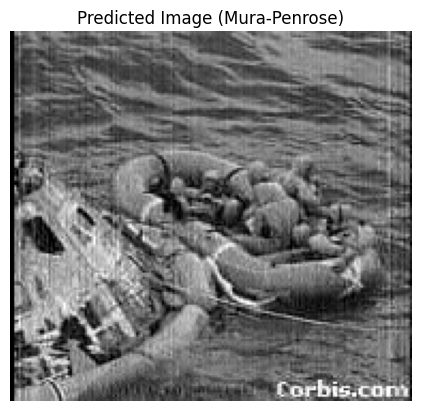

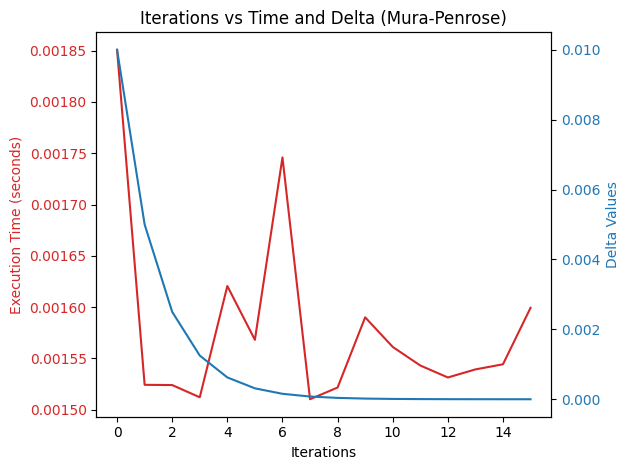

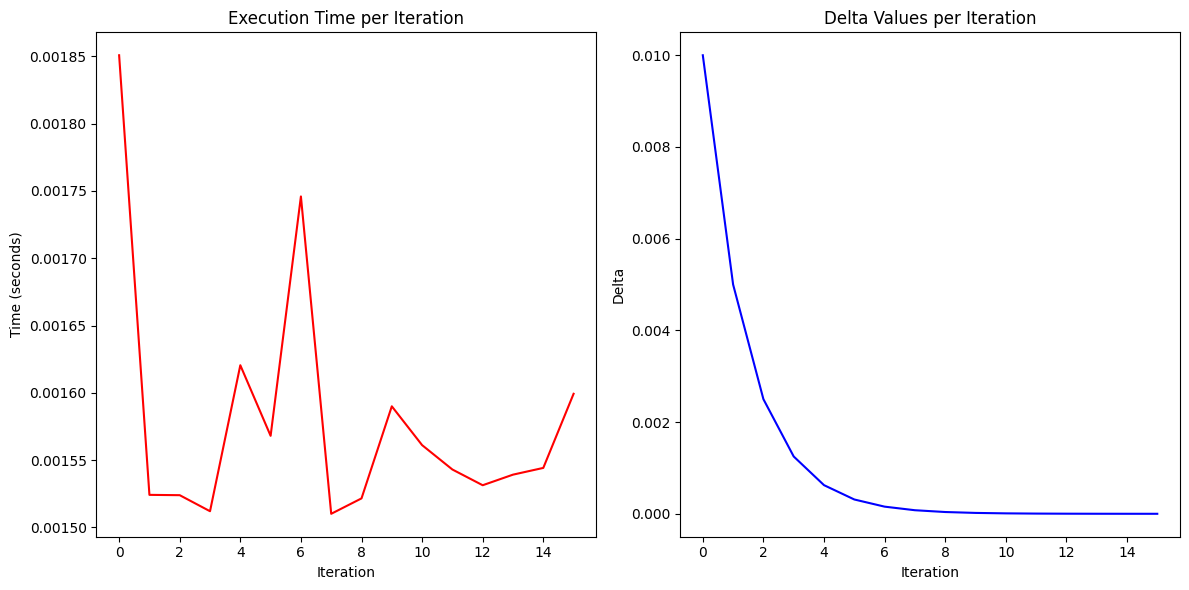


--- Efficiency Report for Mura-Penrose ---
Total Iterations: 16
Delta Value at Last Iteration: 3.0517578125e-07
Total Time Taken: 0.02529 seconds
Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied


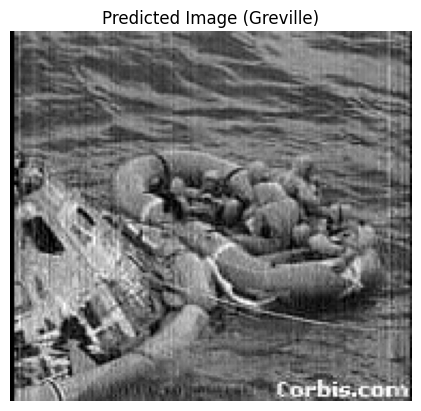

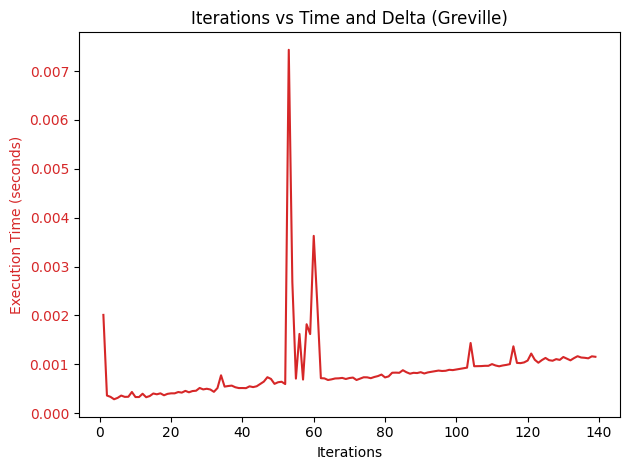

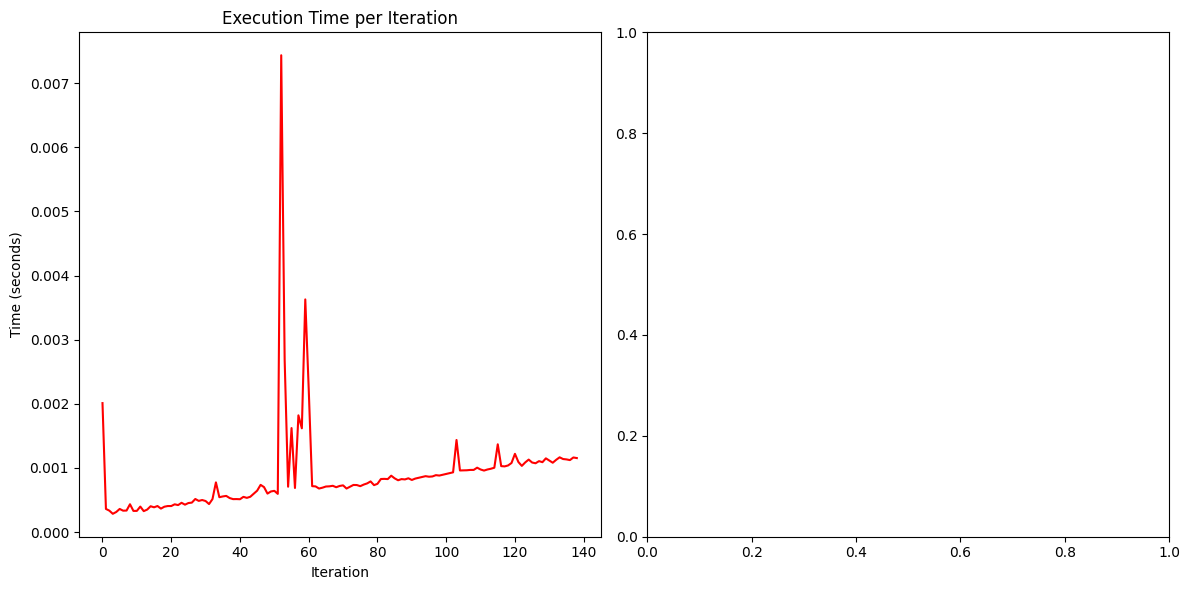


--- Efficiency Report for Greville ---
Total Iterations: 139
Total Time Taken: 0.12088 seconds
Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied


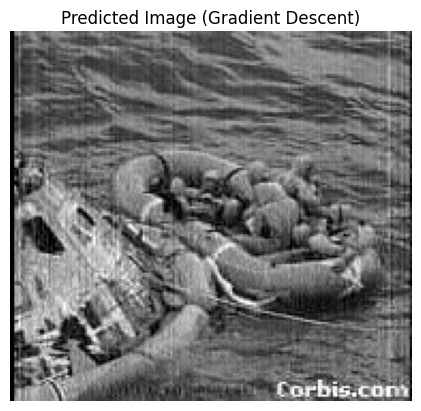

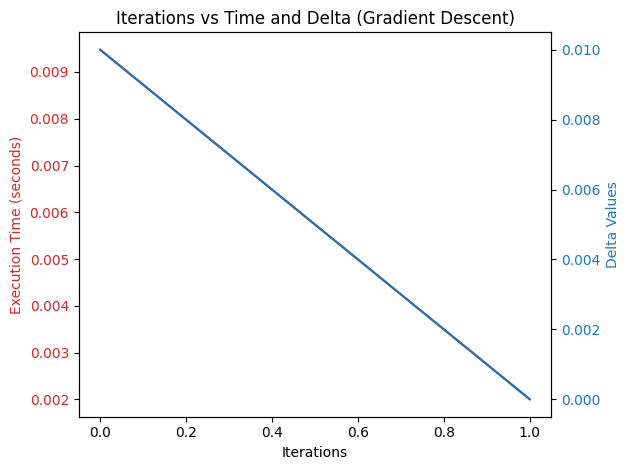

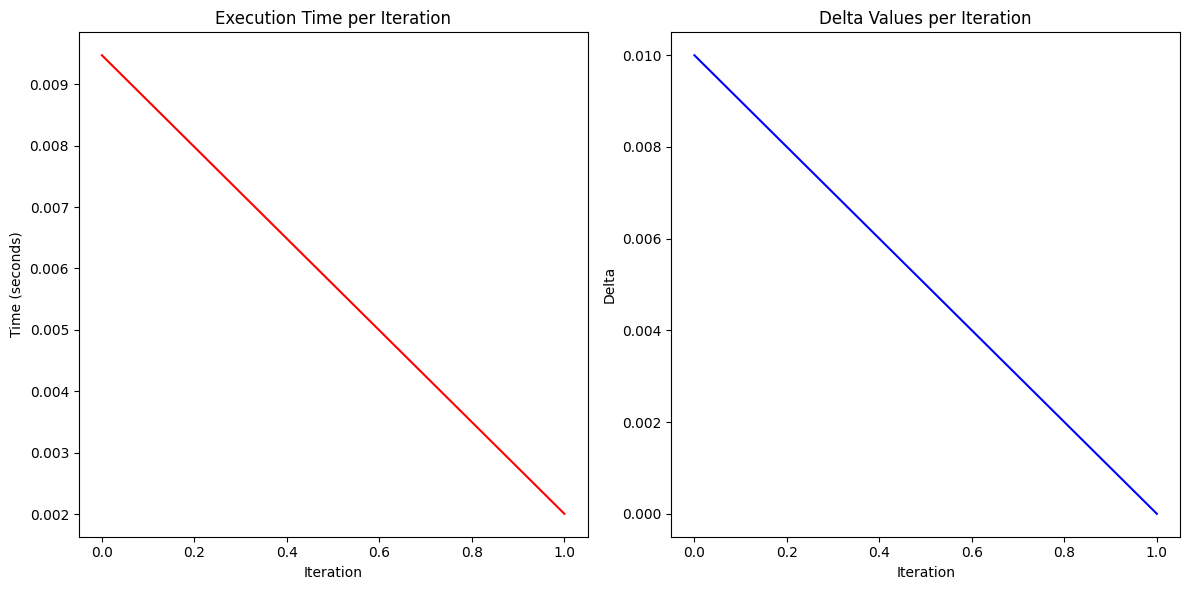


--- Efficiency Report for Gradient Descent ---
Total Iterations: 2
Delta Value at Last Iteration: 1e-06
Total Time Taken: 0.01148 seconds
Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Not satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied


In [127]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

def calculate_pseudo_inverse(mat, delta_start, epsilon_threshold=1e-5, max_iter=1000):
    identity = np.eye(mat.shape[0])
    delta = delta_start
    execution_times, delta_values, iteration_numbers = [], [], []

    for i in range(max_iter):
        start_time = time.time()

        pseudo_inverse = mat.T @ np.linalg.inv(mat @ mat.T + delta**2 * identity)
        delta_half = delta / 2

        execution_times.append(time.time() - start_time)
        delta_values.append(delta)
        iteration_numbers.append(i)

        if np.linalg.norm(pseudo_inverse - mat.T @ np.linalg.inv(mat @ mat.T + delta_half**2 * identity)) < epsilon_threshold:
            break

        delta = delta_half

    return pseudo_inverse, iteration_numbers, execution_times, delta_values

def greville_algorithm(mat, delta, epsilon=1e-5):
    first_row = mat[0]
    denominator = np.dot(first_row.T, first_row)
    pseudo_inverse = np.vstack(first_row / denominator if denominator != 0 else first_row)

    current_matrix = np.array([first_row])
    num_rows = mat.shape[0]

    iteration_time_list = []  # Час на кожну ітерацію Греввіля
    iteration_index_list = []  # Iteration numbers for Greville

    for j in range(1, num_rows):
        start_time = time.time()  # Start timing for each iteration

        current_row = mat[j].reshape(-1, 1)
        identity_matrix = np.identity(current_matrix.shape[1])
        proj_matrix = identity_matrix - np.dot(pseudo_inverse, current_matrix)

        current_matrix = np.vstack([current_matrix, mat[j]])
        # Calculate denominator for update
        denominator = np.dot(current_row.T, np.dot(proj_matrix, current_row))[0, 0]

        if np.abs(denominator) < epsilon:
            correction_matrix = np.dot(pseudo_inverse, pseudo_inverse.T)
            denominator = 1 + np.dot(current_row.T, np.dot(correction_matrix, current_row))
            pseudo_inverse = np.hstack([
                pseudo_inverse - np.dot(proj_matrix, np.dot(current_row, np.dot(current_row.T, pseudo_inverse))) / denominator,
                np.dot(correction_matrix, current_row) / denominator
            ])
        else:
            pseudo_inverse = np.hstack([
                pseudo_inverse - np.dot(proj_matrix, np.dot(current_row, np.dot(current_row.T, pseudo_inverse))) / denominator,
                np.dot(proj_matrix, current_row) / denominator
            ])

        iteration_time_list.append(time.time() - start_time)
        iteration_index_list.append(j)

    return pseudo_inverse, iteration_index_list, iteration_time_list

def normalize_matrix(mat):
    min_val = np.min(mat)
    max_val = np.max(mat)
    return (mat - min_val) / (max_val - min_val)

def show_image(mat, img_title):
    normalized_img = np.clip(mat * 255, 0, 255).astype(np.uint8)
    img = Image.fromarray(normalized_img)
    plt.imshow(img, cmap='gray')
    plt.title(img_title)
    plt.axis('off')
    plt.show()

def plot_time_and_iterations(iter_indices, exec_times, delta_vals=None, method_label="Method"):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Execution Time (seconds)', color='tab:red')
    ax1.plot(iter_indices, exec_times, color='tab:red', label="Execution Time")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    if delta_vals is not None:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Delta Values', color='tab:blue')
        ax2.plot(iter_indices, delta_vals, color='tab:blue', label="Delta Values")
        ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Iterations vs Time and Delta ({method_label})')
    fig.tight_layout()
    plt.show()

def performance_summary(exec_times, delta_vals):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(range(len(exec_times)), exec_times, color='red')
    axes[0].set_title('Execution Time per Iteration')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Time (seconds)')

    if delta_vals:
        axes[1].plot(range(len(delta_vals)), delta_vals, color='blue')
        axes[1].set_title('Delta Values per Iteration')
        axes[1].set_xlabel('Iteration')
        axes[1].set_ylabel('Delta')

    plt.tight_layout()
    plt.show()

def efficiency_report(iter_indices, exec_times, delta_vals=None, method_label="Method"):
    print(f"\n--- Efficiency Report for {method_label} ---")
    print(f"Total Iterations: {len(iter_indices)}")
    if delta_vals:
        print(f"Delta Value at Last Iteration: {delta_vals[-1]}")
    print(f"Total Time Taken: {sum(exec_times):.5f} seconds")

def validate_pseudo_inverse_properties(A, A_pseudo):
    conditions = [
        (np.allclose(A @ A_pseudo @ A, A), "Condition AA+A = A"),
        (np.allclose(A_pseudo @ A @ A_pseudo, A_pseudo), "Condition A+AA+ = A+"),
        (np.allclose(A @ A_pseudo, (A @ A_pseudo).T), "Condition AA+ is symmetric"),
        (np.allclose(A_pseudo @ A, (A_pseudo @ A).T), "Condition A+A is symmetric")
    ]

    for condition, desc in conditions:
        print(f"{desc}: {'Satisfied' if condition else 'Not satisfied'}")

    return [condition for condition, _ in conditions]

def gradient_ascent_method(mat, delta_start, initial_learning_rate=0.001, epsilon_threshold=1e-5, max_iter=1000, min_delta=1e-6):
    E_mat = np.eye(mat.shape[0])
    delta = delta_start
    learning_rate = initial_learning_rate
    iteration_times, delta_values, iteration_indices = [], [], []

    for iter_index in range(max_iter):
        start_time = time.time()
        pseudo_inv = mat.T @ np.linalg.inv(mat @ mat.T + delta**2 * E_mat)
        grad = 2 * delta * np.trace(np.dot(pseudo_inv.T, pseudo_inv))

        learning_rate = initial_learning_rate / (1 + 0.01 * iter_index)
        new_delta = delta - learning_rate * grad
        new_delta = max(new_delta, min_delta)

        iteration_times.append(time.time() - start_time)
        delta_values.append(delta)
        iteration_indices.append(iter_index)

        if abs(new_delta - delta) < epsilon_threshold:
            break

        delta = new_delta

    return pseudo_inv, iteration_indices, iteration_times, delta_values

def main_execution():
    # Load the images
    input_image = Image.open("x1.bmp")
    output_image = Image.open("y2.bmp")

    # Convert images to matrices and normalize
    input_matrix = normalize_matrix(np.array(input_image, dtype=float))
    output_matrix = normalize_matrix(np.array(output_image, dtype=float))
    print(input_matrix.shape)

    # Mura-Penrose Method
    pseudo_inv_mura, iter_counts, iter_times, delta_vals = calculate_pseudo_inverse(input_matrix, 0.01)
    A_mura = output_matrix @ pseudo_inv_mura
    predicted_mura = A_mura @ input_matrix
    show_image(predicted_mura, img_title='Predicted Image (Mura-Penrose)')

    plot_time_and_iterations(iter_counts, iter_times, delta_vals, "Mura-Penrose")
    performance_summary(iter_times, delta_vals)
    efficiency_report(iter_counts, iter_times, delta_vals, "Mura-Penrose")
    validate_pseudo_inverse_properties(input_matrix, pseudo_inv_mura)

    # Greville Method
    pseudo_inv_greville, iter_greville, iter_times_greville = greville_algorithm(input_matrix, 0.01)
    A_greville = output_matrix @ pseudo_inv_greville
    predicted_greville = A_greville @ input_matrix
    show_image(predicted_greville, img_title='Predicted Image (Greville)')

    plot_time_and_iterations(iter_greville, iter_times_greville, method_label="Greville")
    performance_summary(iter_times_greville, [])
    efficiency_report(iter_greville, iter_times_greville, method_label="Greville")
    validate_pseudo_inverse_properties(input_matrix, pseudo_inv_greville)

    # Gradient Descent Method
    pseudo_inv_gradient, iter_grad, iter_times_grad, delta_vals_grad = gradient_ascent_method(input_matrix, 0.01)
    A_gradient = output_matrix @ pseudo_inv_gradient
    predicted_gradient = A_gradient @ input_matrix
    show_image(predicted_gradient, img_title='Predicted Image (Gradient Descent)')

    plot_time_and_iterations(iter_grad, iter_times_grad, delta_vals_grad, "Gradient Descent")
    performance_summary(iter_times_grad, delta_vals_grad)
    efficiency_report(iter_grad, iter_times_grad, delta_vals_grad, "Gradient Descent")
    validate_pseudo_inverse_properties(input_matrix, pseudo_inv_gradient)

if __name__ == "__main__":
    main_execution()
